# Notebook Dedicated to Study the Response of the Trained Classifier when Passing Real Data sets to perform Predictions

In [1]:
#import uproot
import numpy as np

import pickle
import glob

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager

import seaborn as sn
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.losses import BinaryCrossentropy
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.utils import shuffle

# Useful Functions

In [2]:
import colorsys
# Función para generar variantes más claras y más oscuras de un color
def generate_color_variants(base_color, num_variants, factor = 0.3):
    # Convertir el color base a valores de HSV
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    
    # Generar variantes
    variants = []
    for i in range(1, num_variants + 1):
        # Hacer el color más claro
        lighter = colorsys.hls_to_rgb(h, min(1, l * (1 + factor * i)), s)
        # Hacer el color más oscuro
        darker = colorsys.hls_to_rgb(h, max(0, l * (1 - factor * i)), s)
        variants.append(lighter)
        variants.append(darker)
        
    return variants

# Color base (rojo)
base_red = (1, 0, 0) # RGB para rojo puro
# Color base (azuk)
base_blue = (0, 0, 1) # RGB para azul puro
num_variants = 5

red_variants = generate_color_variants(base_red, num_variants)
blue_variants = generate_color_variants(base_blue, num_variants)

# Load Datasets

## Define Cuts used to Contruct the Dataset

In [2]:
# ======== Define the cuts used to construct the Dataset ========
image_dim = (10, 10)

energy_inf_cut = 2.5
energy_sup_cut = 12

posr_cut = 5500

time_res_inf_cut = -1
time_res_sup_cut = 5

nhits_cut = 20 #Nhits cut to be applied after the time residual cuts

dcFlag_cut = 0x2100000042C2

Bi_214_max_energy = 3.5 #end-point energy of the Bi214 (MeV) (value from MC)
Po_214_min_energy = 0.5 #int-point energy of the Po214 (MeV) (value from MC)
Po_214_max_energy = 1.5 #end-point energy of the Po214 (MeV) (value from MC)
dt_window = 1         #range of the time window to try to find a delayed Po214 for a prompt Bi214 in miliseconds
dr_window = 1000      # upper limit for the distance between the prompt and the delayed reconstructed positions in milimeters

# ======== Cuts to select the events in the loaded Datasets ========
energy_cut_train = 7 # Superior limit on events to choose

## Real Dataset

In [3]:
#Load Data
real_dataset_dir = 'C:/Users/joanc/jupyter notebooks/solar neutrino analysis/real data analysis/real_dataset_ML/'
fname = f'real_dataset_Dim_{image_dim[0]}_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

df_real_data = pd.read_csv(real_dataset_dir + fname)
df_real_data

,Unnamed: 0,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,...,pixel_92,pixel_93,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radius (mm)
0,0,0.000000,0.0,0.000,0.000000,0.250000,0.000000,0.000000,0.100000,0.000000,...,1.0,0.0,0.250000,0.000000,0.333333,0.000000,0.000000,0.000000,4.044874,2425.253906
1,1,0.000000,0.0,0.000,0.500000,0.000000,0.000000,0.058824,0.125000,0.000000,...,0.0,0.0,0.000000,0.000000,0.058824,0.000000,0.142857,0.160000,3.546911,3926.669922
2,2,0.333333,0.0,0.000,0.000000,0.000000,0.125000,0.000000,0.250000,0.200000,...,0.0,1.0,0.333333,0.000000,0.000000,0.000000,0.000000,0.090909,2.680639,3859.642090
3,3,0.000000,0.0,0.000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.052632,0.000000,0.038462,4.298751,5214.634766
4,4,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.200000,0.083333,0.300000,...,0.0,1.0,0.250000,0.142857,0.200000,0.166667,0.300000,0.076923,3.584208,1686.395874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,204,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050000,...,0.0,0.0,0.250000,0.125000,0.076923,0.166667,0.150000,0.190476,5.592613,2606.778076
205,205,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.568719,4906.762695
206,206,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.052632,0.068966,...,0.0,0.0,0.066667,0.000000,0.095238,0.000000,0.034483,0.040000,6.136848,4055.741943
207,207,0.000000,0.0,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.615669,5470.117676


## MC Train Dataset
Load the trainning data as the main MC Data

In [ ]:
# ========= MC Dataset Directories =========
mc_dataset_dir_train = "E:/Data/solars/mc/ML Data/Train/pd_dataframe/"
fname = f'df_Dim_{image_dim[0]}_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

#Load Data:
df_mc_data_train = pd.read_csv(mc_dataset_dir_train + fname)

# ========= Observables Selection =========

# Separate 8B solar Nue from 208Tl simulated Events:
mc_data_sig_train = (df_mc_data_train[df_mc_data_train['IsNu'] == 1])
mc_data_bkg_train = (df_mc_data_train[df_mc_data_train['IsTl'] == 1])

#Select Observables:
mc_energy_solar_train = np.array(mc_data_sig_train['energy (MeV)'])
mc_energy_208tl_train = np.array(mc_data_bkg_train['energy (MeV)'])

## MC Test Dataset
Load the test data set to compare the MC Data model predictions with the predictions on real data

In [4]:
pixel_pattern = r'^pixel_\d+$'

# ========= MC Dataset Directories =========
mc_dataset_dir_test = "E:/Data/solars/mc/ML Data/Test/pd_dataframe/"
fname = f'df_Dim_{image_dim[0]}_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns.csv'

#Load Data:
df_mc_data_test = pd.read_csv(mc_dataset_dir_test + fname)

# Event Selection based on enrgy of train:
energy_condition = (df_mc_data_test['energy (MeV)'] <= energy_cut_train)
df_mc_data_test = df_mc_data_test[energy_condition]

# ========= Observables Selection =========

# ------- Separate 8B solar Nue from 208Tl simulated Events -------:
mc_data_sig_test = (df_mc_data_test[df_mc_data_test['IsNu'] == 1])
mc_data_bkg_test = (df_mc_data_test[df_mc_data_test['IsTl'] == 1])

#Select signal and Background Observables:
#Sig:
mc_pixel_sig_test = mc_data_sig_test.filter(regex=pixel_pattern)
mc_energy_sig_test = mc_data_sig_test[['energy (MeV)']]
mc_radi_sig_test = mc_data_sig_test[['radius (mm)']]
mc_labels_sig_test = pd.DataFrame(mc_data_sig_test, columns = ['IsNu', 'IsTl'])

mc_energy_sig_test = np.array(mc_energy_sig_test).T[0]

#Bkg:
mc_pixel_bkg_test = mc_data_bkg_test.filter(regex=pixel_pattern)
mc_energy_bkg_test = mc_data_bkg_test[['energy (MeV)']]
mc_radi_bkg_test = mc_data_bkg_test[['radius (mm)']]
mc_labels_bkg_test = pd.DataFrame(mc_data_bkg_test, columns = ['IsNu', 'IsTl'])

# ------- Extract only features, keeping track of the labels of each event -------
mc_pixel_test = df_mc_data_test.filter(regex=pixel_pattern)
mc_energy_test = df_mc_data_test[['energy (MeV)']]
mc_radi_test = df_mc_data_test[['radius (mm)']]
mc_labels_test = pd.DataFrame(df_mc_data_test, columns = ['IsNu', 'IsTl'])

mc_pixel_test = np.array(mc_pixel_test)
mc_energy_test = np.array(mc_energy_test)
mc_radi_test = np.array(mc_radi_test)
mc_labels_test = np.array(mc_labels_test)

In [5]:
mc_energy_sig_test

array([3.25529385, 4.91098213, 4.64432001, ..., 6.08302784, 5.33064842,
       2.88384604])

### MC Scaling

Scale the MC events of 8B Solar Nue and 208Tl to compare with the observed data. Is necessary to obtain the scaling factors to normalize the MC data distributions. The scaling factors are obtained as follows:
1. Obtain an efficiency of selection of MC events $\epsilon_{eff}$ through the ratio of intial and final Number of events;
2. Obtain the live-time of the real dataset L$_{tot}$;
3. Obtain an expected event rate N$_{rate}$ to estimate the number of MC event within the lifetime N$_{MC_{Scaled}}$;
4. Obtain the scaling factors through the ratio N$_{MC_{Scaled}}$ / N$_{MC_f}$.

208-tl Rate? A clue: https://www.snolab.ca/snoplus/private/DocDB/0085/008543/001/March_25_Pre_CM_Tl208_Background_Call.pdf

For now, just represent MC solar data.

The MC scaling factors must be the same for the training and test datasets

#### Define constants:

In [6]:
N_solarNue_ev_per_day = 0.109*24 #(N_ev per hour)*(24h) = N_ev per day of Solar 8B-Nue
dataset_tot_lf_day = 308.79705514596526  #Total Lifetime in Days

#### Train Dataset Scaling

In [101]:
# ===================== Solar Scaling =====================

# Load and compute the information of initial Nº of events:
main_dir = f'E:/Data/solars/mc/ML Data/Train/np_arrays/E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns/'
solar_fname = 'solarNue_n_init_evs_*.npy'
flist_solar = glob.glob(main_dir + solar_fname)

N_init_solar = []  #Nº of initial solar 8B events 

#Extraction of Nº init events --------
for fsolar_i in flist_solar:
    n_init_ev = np.load(fsolar_i)[0]
    N_init_solar.append(n_init_ev)
N_init_solar = np.array(N_init_solar)
# ------------------------------------

N_init_solar = np.sum(N_init_solar) # Initial Nº of events
N_final_solar = len(energy_mc_solar_train) # Final Nº of events

eff_solar = N_final_solar/N_init_solar  #Efficiency
print(f'MC Solar Efficiency = {eff_solar}')

N_scaled_mc_solar = dataset_tot_lf_day * N_solarNue_ev_per_day * eff_solar
train_scale_factor_solar = N_scaled_mc_solar / N_final_solar

print(f'Solar events scaled from {N_final_solar} to {N_scaled_mc_solar}')
print(f'Solar Scale factor for Train Dataset = {train_scale_factor_solar}')

# ===================== 208-Tl Scaling =====================

#(...)

MC Solar Efficiency = 0.3534614573966079
Solar events scaled from 987759 to 285.5307943087781
Solar Scale factor for Train Dataset = 0.00028906929150610434


#### Test Dataset Scaling

In [7]:
# ===================== Solar Scaling =====================

# Load and compute the information of initial Nº of events:
main_dir = f'E:/Data/solars/mc/ML Data/Test/np_arrays/E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns/'
solar_fname = 'solarNue_n_init_evs_*.npy'
flist_solar = glob.glob(main_dir + solar_fname)

N_init_solar = []  #Nº of initial solar 8B events 

#Extraction of Nº init events --------
for fsolar_i in flist_solar:
    n_init_ev = np.load(fsolar_i)[0]
    N_init_solar.append(n_init_ev)
N_init_solar = np.array(N_init_solar)
# ------------------------------------

N_init_solar = np.sum(N_init_solar) # Initial Nº of events
N_final_solar = len(mc_energy_sig_test) # Final Nº of events

eff_solar = N_final_solar/N_init_solar  #Efficiency
print(f'MC Solar Efficiency = {eff_solar}')

N_scaled_mc_solar = dataset_tot_lf_day * N_solarNue_ev_per_day * eff_solar
test_scale_factor_solar = N_scaled_mc_solar / N_final_solar

print(f'Solar events scaled from {N_final_solar} to {N_scaled_mc_solar}')
print(f'Solar Scale factor for Test Dataset = {test_scale_factor_solar}')

# ===================== 208-Tl Scaling =====================

#(...)

MC Solar Efficiency = 0.2872023905150532
Solar events scaled from 44693 to 232.00585233576874
Solar Scale factor for Test Dataset = 0.005191100448297692


# Data Processing - Applied to Real Dataset and Test Dataset

## Data Selection and Extraction

In [8]:
pixel_pattern = r'^pixel_\d+$'

# Energy of trainning Condition:
energy_condition = (df_real_data['energy (MeV)'] <= energy_cut_train)

#Real Data Selection
df_real = df_real_data[energy_condition]

df_pixel_real = df_real.filter(regex=pixel_pattern)
df_energy_real = df_real[['energy (MeV)']]
df_radius_real = df_real[['radius (mm)']]

df_pixel_real = np.array(df_pixel_real)
df_energy_real = np.array(df_energy_real)
df_radius_real = np.array(df_radius_real)

## Data transformation

### Pipeline MinMaxScaler(StandardScaler())

In [9]:
# Transformation History

#Intervals for MinMax Scaler ------------------------------------
epsilon = 1e-2
min_val = np.min(df_pixel_real) + epsilon # equals to zero + epsilon
max_val = np.max(df_pixel_real) + epsilon # equals to one + epsilon
# ---------------------------------------------------------------

scaler_pixels = Pipeline([('standardization', StandardScaler()),
                        ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])

scaler_energy = Pipeline([('standardization', StandardScaler()),
                        ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])

scaler_position = Pipeline([('standardization', StandardScaler()),
                        ('minmax', MinMaxScaler(feature_range=(min_val, max_val)))])

### Real Dataset Transformation

In [10]:
#pixel_train_transf = scaler_pixels_train.fit_transform(df_pixel_train)
pixel_transf_real = np.array(df_pixel_real) + epsilon
energy_transf_real = scaler_energy.fit_transform(df_energy_real).T[0]

#radial position to volume normalization Transformationm
vol = posr_cut**3 
position_transf_volnorm_real = (df_radius_real.T[0]**3)/vol

position_transf_real = scaler_position.fit_transform(position_transf_volnorm_real.reshape(-1, 1)).T[0]

### Test Dataset Transformation

In [11]:
#pixel_train_transf = scaler_pixels_train.fit_transform(df_pixel_train)
mc_pixel_transf_test = np.array(mc_pixel_test) + epsilon
mc_energy_transf_test = scaler_energy.fit_transform(mc_energy_test).T[0]

#radial position to volume normalization Transformationm
vol = posr_cut**3 
mc_position_transf_volnorm_test = ((mc_radi_test).T[0])**3/vol

mc_position_transf_test = scaler_position.fit_transform(mc_position_transf_volnorm_test.reshape(-1, 1)).T[0]

#### Sig. and Bkg. Separation on Test Dataset

In [12]:
#Separar sig from bkg and train from test
IsNu = np.array([1,0])
IsTl = np.array([0,1])

sig_mask_test = np.all(mc_labels_test == IsNu, axis=1)
bkg_mask_test = np.all(mc_labels_test == IsTl, axis=1)

mc_pixel_transf_test_sig = mc_pixel_transf_test[sig_mask_test]
mc_energy_transf_test_sig = mc_energy_transf_test[sig_mask_test]
mc_position_transf_test_sig = mc_position_transf_test[sig_mask_test]

# Load the Classifier Model

In [13]:
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable(package="Custom", name="PixelHintInitializer")
class PixelHintInitializer(tf.keras.initializers.Initializer):
    def __init__(self, weights_hint):
        self.weights_hint = np.array(weights_hint)

    def __call__(self, shape, dtype=None):
        W = np.tile(self.weights_hint.reshape(-1, 1), (1, shape[1]))
        return tf.convert_to_tensor(W, dtype=dtype)

    def get_config(self):
        return {"weights_hint": self.weights_hint.tolist()}

In [14]:
model_dir = 'C:/Users/joanc/jupyter notebooks/solar neutrino analysis/Machine Learning/TensorFlow Frame/Sequential Models/models save/10x10/optimized models/pipeline_std_minmax/'
model_name = f'Seq_MLM1_E_{energy_inf_cut}_{energy_cut_train}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns'

model = tf.keras.models.load_model(model_dir + model_name + '.keras', custom_objects={"gelu": tf.keras.activations.gelu})
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image_input (InputLayer)      │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ imag_ly_0 (Dense)             │ (None, 94)                │           9,494 │ image_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ energy_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ position_input (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 96)                │               0 │ imag_ly_0[0][0],           │
│                               │                           │                 │ energy_input[0][0],        │
│                               │                           │                 │ position_input[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_ly_0 (Dense)              │ (None, 29)                │           2,813 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bdo_ly_1 (Dense)              │ (None, 24)                │             720 │ bdo_ly_0[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 24)                │               0 │ bdo_ly_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ado_ly_0 (Dense)              │ (None, 14)                │             350 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ nu_predict (Dense)            │ (None, 2)                 │              30 │ ado_ly_0[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 40,223 (157.12 KB)

 Trainable params: 13,407 (52.37 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,816 (104.75 KB)

# Model Predictions

In [15]:
# ======== MC Predictions ========
predictions_mc_sig = model.predict([mc_pixel_transf_test_sig, mc_energy_transf_test_sig, mc_position_transf_test_sig])[:,0]  # Model prediction on pure MC signal events

# ======== Real Data Predicions ========
predictions_real = model.predict([pixel_transf_real, energy_transf_real, position_transf_real])  # Model prediction on real data

prediction_real_sig = predictions_real[:,0] # Probability of real data event being an 8B Nue
prediction_real_bkg = predictions_real[:,1] # Probability of real data event being an 208Tl

1397/1397 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


## Model Prediction on MC Test Dataset

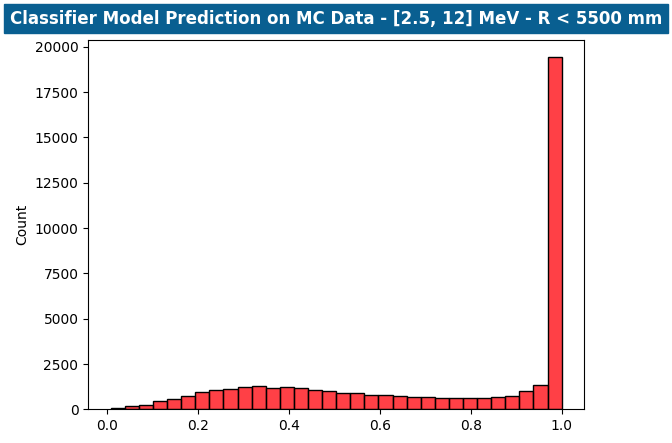

In [115]:
sn.histplot(predictions_mc_sig, color = '#ff0008')
plt.title(f'Classifier Model Prediction on MC Data - [{energy_inf_cut}, {energy_sup_cut}] MeV - R < 5500 mm',
             backgroundcolor='#095f91', color='white', fontsize=12, weight='bold', y=1.02)
plt.show()

## Component Classification Plot on Real Data

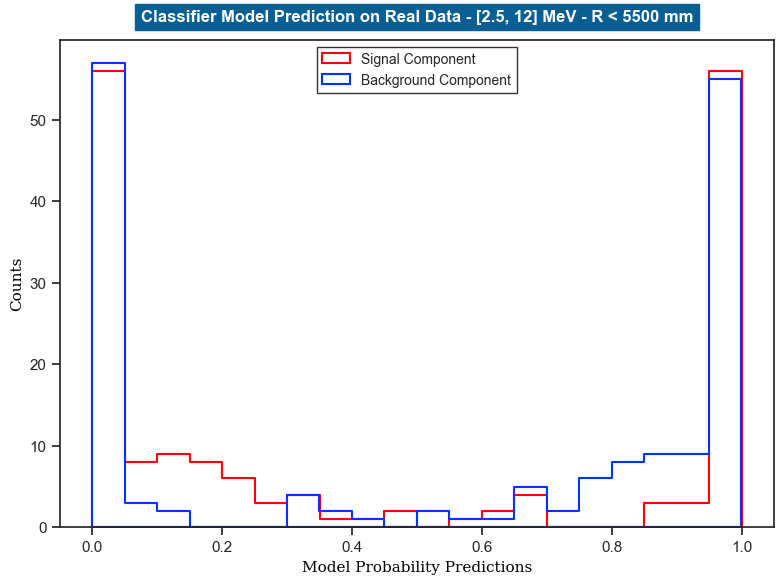

In [116]:
#general_save = False

sn.set_theme(style="ticks")  # o "ticks", "darkgrid", etc.
font_style_title = {'family':'serif', 'weight': 'normal','color':'black','size':11}
font_style_axis= {'family':'serif', 'weight': 'normal','color':'black','size':11}

bins = 20
linewdt = 1.5
plt.figure(figsize=(8, 6))

sn.histplot(prediction_real_sig, bins=bins, label='Signal Component', color='#ff0008',
            linewidth = linewdt, element = 'step', alpha=0.0)
sn.histplot(prediction_real_bkg, bins=bins, label='Background Component', color='#0033ff',
            linewidth = linewdt, element = 'step', alpha=0.0)

# Titles and labels
plt.xlabel('Model Probability Predictions', fontdict = font_style_axis)
plt.ylabel('Counts', fontdict = font_style_axis)
plt.legend(loc = 'upper center', frameon=True, edgecolor='black', fancybox=False, fontsize=10)
#plt.yscale('log')

# General formatting
plt.title(f'Classifier Model Prediction on Real Data - [{energy_inf_cut}, {energy_sup_cut}] MeV - R < 5500 mm',
             backgroundcolor='#095f91', color='white', fontsize=12, weight='bold', y=1.02)

plt.tight_layout()
#if general_save:
#    fig.savefig('figs/Classifier_Model_Output.png', dpi=300, bbox_inches='tight')
plt.show()

## Spectrum of Event's Predicted for various Thresholds 

In [16]:
# Plot title
main_title = 'Classifier Model Predictions - '
title_ev_selec = rf'mask = {hex(dcFlag_cut)} - nhits $\geq {nhits_cut}$ - E: [{energy_inf_cut}, {energy_cut_train}] (MeV) - R $\leq$ {posr_cut} (mm)'
title_bi214_cut = rf'Bi214 cuts: E(Bi214): [{energy_inf_cut}, {Bi_214_max_energy}] (MeV), E(Po214): [{Po_214_min_energy}, {Po_214_max_energy}] (MeV), $\Delta$t = {dt_window} (ms) and $\Delta$r = {dr_window} (mm) Window'
title_ml_feat_cuts = rf'Classifier Training Dataset: Dim($\mathcal{{L}}(\Delta,\alpha)) = {image_dim}$) with $\Delta$ = [{time_res_inf_cut}, {time_res_sup_cut}] (ns)'

full_title = main_title + title_ev_selec + '\n' + title_bi214_cut + '\n' + title_ml_feat_cuts

#Save plot options Name:
save = False
save_dir = 'C:/Users/joanc/jupyter notebooks/solar neutrino analysis/real data analysis/figs/Real Data vs MC/'

main_save_title = 'classifier Model Prediction Spectrum - '
train_cuts_dataset = f'Dim_{image_dim[0]}_E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns'
full_save_title = main_save_title + train_cuts_dataset

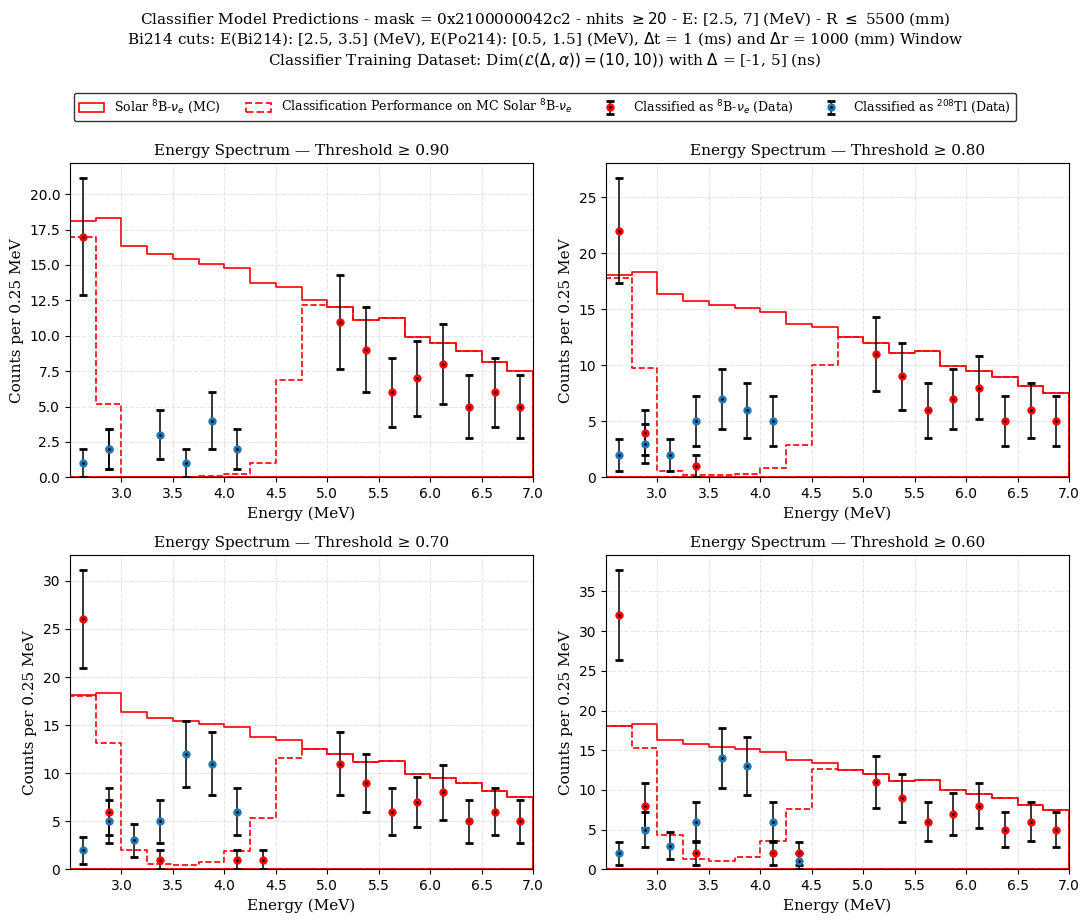

In [17]:
# ============ Font Styles ============
font_style_title = {'family': 'serif', 'weight': 'normal', 'color': 'black', 'size': 18}
font_style_axis = {'family': 'serif', 'weight': 'normal', 'color': 'black', 'size': 11}
font_prop = font_manager.FontProperties(family='serif', weight='normal', size=9)

linewidth = 1.2 #Line width of MC histogram
alpha = 0.0 #degree of MC histogram transparency
elinewidth = 1.1 #Error linewidth

color_sig = '#ff0008'
color_bkg = '#1f77b4'

energy_bwdt = 0.25
thresholds = [0.90, 0.80, 0.70, 0.60]

# ============ Define common binning ============
# Take min/max from all data (before threshold selection)
global_min = min(df_energy_real.min(), df_energy_real.min())  # same array for sig/bkg here
global_max = max(df_energy_real.max(), df_energy_real.max())

bins = np.arange(global_min, global_max + energy_bwdt, energy_bwdt)

# ============ Create figure ============
fig, axes = plt.subplots(2, 2, figsize=(11, 8.5))
axes = axes.flatten()

for i, thr_value in enumerate(thresholds):
    
    # ========= Data Extraction for each threshold ==========
    # Real Data:
    energy_real_sig = np.ravel(df_energy_real[prediction_real_sig >= thr_value])
    energy_real_bkg = np.ravel(df_energy_real[prediction_real_bkg >= thr_value])

    # MC Test Data
    pred_mc_energy_test_sig = np.ravel(mc_energy_sig_test[predictions_mc_sig >= thr_value])
    
    ax = axes[i]

    # ========= Compute histograms (shared bins) ==========
    counts_sig, _ = np.histogram(energy_real_sig, bins=bins)
    counts_bkg, _ = np.histogram(energy_real_bkg, bins=bins)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    error_sig = np.sqrt(counts_sig)
    error_bkg = np.sqrt(counts_bkg)

    # ========= Remove zero-count bins for plotting ==========
    mask_sig = counts_sig > 0
    mask_bkg = counts_bkg > 0

    # ========= Real Data Classification Points plot =========
    ax.errorbar(bin_centers[mask_sig], counts_sig[mask_sig], yerr=error_sig[mask_sig],
                fmt='o', mfc='black', mec=color_sig, ecolor='black',
                elinewidth=elinewidth, capsize=3, mew=2, markersize=4,
                label=r'Classified as $^{8}$B-$\nu_e$ (Data)')
    
    ax.errorbar(bin_centers[mask_bkg], counts_bkg[mask_bkg], yerr=error_bkg[mask_bkg],
                fmt='o', mfc='black', mec=color_bkg, ecolor='black',
                elinewidth=elinewidth, capsize=3, mew=2, markersize=4,
                label=r'Classified as $^{208}$Tl (Data)')

    # ========= MC Histograms of 8B_nue and 208Tl =========
    # Test 8B Histogram:
    sn.histplot(x = mc_energy_sig_test, bins = bins.tolist(), weights = np.ones(len(mc_energy_sig_test))*test_scale_factor_solar,
                color = color_sig, element='step', alpha = alpha, linewidth = linewidth, ax = ax,
                label = r'Solar $^{8}$B-$\nu_e$ (MC)')

    # ========= Model Prediction on test MC 8B-nue Data =========
    sn.histplot(x = pred_mc_energy_test_sig, bins = bins.tolist(), weights = np.ones(len(pred_mc_energy_test_sig))*test_scale_factor_solar,
                color = color_sig, element='step', alpha = alpha, linewidth = linewidth, linestyle='--', ax = ax,
                label = r'Classification Performance on MC Solar $^{8}$B-$\nu_e$')

    
    ax.set_xlabel('Energy (MeV)', fontdict=font_style_axis)
    ax.set_ylabel(f'Counts per {energy_bwdt} MeV', fontdict=font_style_axis)
    ax.set_title(f'Energy Spectrum — Threshold ≥ {thr_value:.2f}', fontdict=font_style_axis)
    #ax.legend(prop=font_style_legend, loc='best', ncol=1, framealpha=0.8)
   
    # Grid
    ax.grid(True, color='gray', alpha=0.2, linestyle='--')
    
    #ax.set_yscale('log')
    ax.set_xlim(bins[0], bins[-1])

#Common legends :
# Obtain the handles and labels of only one plot (just because they share labels!)
handles, labels = axes[0].get_legend_handles_labels()

# Create one legend out of the axis plots
fig.legend(handles, labels,
           ncol = 4,
           loc = 'upper center',        
           bbox_to_anchor = (0.5, 0.99),  # coordinates of the box at the right (x, y)
           frameon = True,              # white background
           edgecolor='black',
           prop = font_prop,
           labelcolor = font_style_axis['color'])

# Ajustar layout dejando espacio arriba (rect define [left, bottom, right, top])
plt.tight_layout(rect=[0, 0, 1, 0.94])  # 0.94 deja espacio suficiente para el título

# Título general con estilo definido
plt.suptitle(full_title, y = 1.08, size = 11, weight = 'normal', family = 'serif', color = 'black')

if save:
    plt.savefig(save_dir + full_save_title + '.png', dpi=300, bbox_inches='tight')
    
plt.show()